In [1]:
import os
import sys
sys.path.append('/mnt/mnt/5TB_slot2/Tobias')
sys.path.append('/mnt/mnt/5TB_slot2/Tobias/ismrmrd-python-tools/ismrmrdtools ')
sys.path.append('/mnt/mnt/5TB_slot2/Tobias/TobiasPy/fastMRI')
sys.path.append('/mnt/mnt/4TB_pcie/fastBrain/')
import h5py
import numpy as np
import numpy.fft as nf
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from models.unet.unet_model import UnetModel as UnetModel
from FF_net import FF_net
from FF_net import FF_simple_net
from FF_net import FF_net_tanh
from FF_net import Complex_net
import argparse
from common.args import Args
import models.unet.run_unet  as Run
import torch.nn as nn
import logging
import pathlib
import random
from torch.utils.data import Dataset
import time
from torch.nn import functional as F
import shutil
from tensorboardX import SummaryWriter
import torchvision
from torchvision import transforms, utils
import net_utils as nu
import calendar
import datetime

import sigpy as sp
import sigpy.plot as pl
import vd_spiral

from wrap_net import wrap_net

import ismrmrd
import ismrmrdtools
from ismrmrdtools import show, simulation, transform
from ismrmrdtools import coils

%load_ext autoreload
%autoreload 2

In [2]:
sys.argv=['']
def create_arg_parser():
    timestamp = calendar.timegm(time.gmtime())
    human_readable = datetime.datetime.fromtimestamp(timestamp).isoformat()
    parser = argparse.ArgumentParser(description="ML parameters")
    parser.add_argument('--num-pools', type=int, default=4, help='Number of U-Net pooling layers')
    parser.add_argument('--drop-prob', type=float, default=0.0, help='Dropout probability')
    parser.add_argument('--num-chans', type=int, default=32, help='Number of U-Net channels')

    parser.add_argument('--batch-size', default=4096, type=int, help='Mini batch size')
    parser.add_argument('--num-epochs', type=int, default=150, help='Number of training epochs')
    parser.add_argument('--lr', type=float, default=0.001, help='Learning rate')
    parser.add_argument('--lr-step-size', type=int, default=100,
                        help='Period of learning rate decay')
    parser.add_argument('--lr-gamma', type=float, default=0.1,
                        help='Multiplicative factor of learning rate decay')
    parser.add_argument('--weight-decay', type=float, default=0.01,
                        help='Strength of weight decay regularization')
    parser.add_argument('--momentum', type=float, default=0.1,
                        help='Strength of optimizer momentum')

    parser.add_argument('--report-interval', type=int, default=10000, help='Period of loss reporting')
    parser.add_argument('--data-parallel', default=True,
                        help='If set, use multiple GPUs using data parallelism')
    parser.add_argument('--device', type=str, default='cuda',
                        help='Which device to train on. Set to "cuda" to use the GPU')
    parser.add_argument('--exp-dir', type=pathlib.Path, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_'+str(human_readable),
                        help='Path where model and results should be saved')
    parser.add_argument('--resume', action='store_true', default=False,
                        help='If set, resume the training from a previous model checkpoint. '
                             '"--checkpoint" should be set with this')
    parser.add_argument('--checkpoint', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_'+str(human_readable)+'/best_model.pt',
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--logdir', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/log/ff_lrelu_'+str(human_readable),
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--seed', default=42, type=int, help='Seed for random number generators')
    parser.add_argument('--resolution', default=160, type=int, help='Resolution of images')
    parser.add_argument('--device_ids', default=[2,3] , help='GPUS used')
    parser.add_argument('--acceleration', default=4, help='Acceleration factor used in artifical undersampling')
    return parser
args=create_arg_parser().parse_args()

In [3]:
class SliceData(Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """
    
    def __init__(self, root="/mnt/mnt/5TB_slot2/fastMRI/multicoil_train", sample_rate=1.):
        self.examples = []
        #potential to apply pre-process transform
        files = list(pathlib.Path(root).iterdir())
        if sample_rate < 1:
            #random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]
        for fname in sorted(files):
            print(fname)
            try:
                #print(h5py.File(fname, 'r').keys())
                #maybe also only randomly select parts of slices. Otherwise lot of outer noise-like structures.
                xml = h5py.File(fname, 'r')['ismrmrd_header']
                kspace = h5py.File(fname, 'r')['kspace']
                num_slices = kspace.shape[0]
                num_channels=kspace.shape[1]
                if (kspace.shape[-2]<args.resolution) or (kspace.shape[-1]<args.resolution) or num_channels!=20:
                    continue
                print(len(self.examples))
                for slice in range(num_slices):
                    print(slice)
                    crop_size = (min(args.resolution, kspace.shape[-2]),min(args.resolution, kspace.shape[-1]))
                    full=nu.to_tensor(nu.center_crop(kspace[slice],crop_size))
                    #full=nu.center_crop(full,crop_size)
                    #full = (full-torch.min(full))/(torch.max(full)-torch.min(full))
                    print(full.shape)
                    #usam = nu.to_tensor(full)
                    usam = nu.apply_mask(full)[0]
                    #usam = nu.to_tensor(usam)
                    #usam = nu.center_crop(usam, crop_size)
                    #usam = (usam-torch.min(usam))/(torch.max(usam)-torch.min(usam))
                    print(usam.shape)
                    self.examples += [(fname, slice, full, usam)]
            except:
                print("Couldn't open file")
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, i):
        fname, slice, f, t = self.examples[i]
#         with h5py.File(fname, 'r') as data:
#             full=to_tensor(data['kspace'][slice])
#             crop_size = (min(args.resolution, full.shape[-3]),min(args.resolution, full.shape[-2]))          
#             full=complex_center_crop(full,crop_size)
            
#             kspace = to_tensor(data['kspace'][slice])
#             crop_size = (min(args.resolution, kspace.shape[-3]), min(args.resolution, kspace.shape[-2]))
#             kspace=apply_mask(kspace)[0]
#             kspace = complex_center_crop(kspace, crop_size)
            
        return (f, t)

In [4]:
def create_data_loaders():
    #batch_size=32
    #mask_func = None
    #if args.mask_kspace:
    #    mask_func = MaskFunc(args.center_fractions, args.accelerations)
    train_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_train",sample_rate=0.5)
    dev_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain",sample_rate=0.5)
    test_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain",sample_rate=0.05)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )
    dev_loader = DataLoader(
        dataset=dev_data,
        batch_size=args.batch_size,
        num_workers=0,
        pin_memory=True,
    )
    test_loader=None
#     test_loader = DataLoader(
#         dataset=test_data,
#         num_workers=0,
#         pin_memory=True,
#     )
    return train_loader, dev_loader, test_loader

In [5]:
t=time.time()
train_loader, dev_loader, test_loader= create_data_loaders()
print("Time taken to load data: ",time.time()-t)

/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002428.h5
0
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002570.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002576.h5
124
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
t

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_201_6002917.h5
250
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_201_6002998.h5
372
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_201_6003027.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_201_6003029.h5
484
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
t

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000551.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000553.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000561.h5
612
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000321.h5
708
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 1

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000409.h5
818
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 1

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000484.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000486.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000488.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000496.h5
930
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([2

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000600.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000607.h5
1042
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002015.h5
1154
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 16

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002197.h5
1264
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 16

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002246.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090155.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090156.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090159.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090162.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090175.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_2090179.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXFLAIR_200_6002625.h5
44
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXFLAIR_210_6001943.h5
156
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Siz

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070053.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070112.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070137.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070203.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070319.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_207_2070321

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_2020553.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_6000277.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_6000357.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_60003

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_6002009.h5
444
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_2

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_202_2020375.h5
666
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060069.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060073.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060091.h5
776
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
10
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
11
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
12
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
13
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt

torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
14
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
15
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_201_6002671.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_202_6000378.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_205_6000098.h5
32
0
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
1
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
2
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
3
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
4
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
5
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
6
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
7
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
8
torch.Size([20, 160, 160, 2])
torch.Size([20, 160, 160, 2])
9

torch.Size([20, 160, 160])
(20, 20, 5, 5)
torch.Size([1390, 20, 160, 160, 2]) torch.Size([1390, 20, 160, 160, 2])


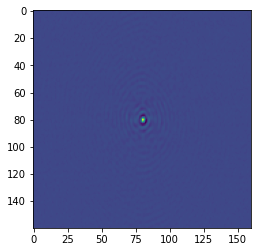

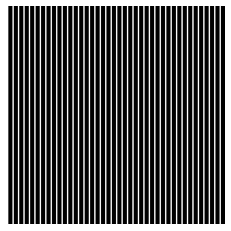

In [6]:
from ismrmrdtools import coils
from ismrmrdtools import grappa
kernel_shape=np.array([5,5,5])
pad=kernel_shape//2
acc=args.acceleration
cols=acc*kernel_shape[0]
rows=acc*kernel_shape[1]
coils=acc*kernel_shape[2]
with torch.no_grad():
        for (kspace, full) in train_loader:
            print(nu.to_complex(kspace[0,:,:,:,:]).shape)
            kernel=grappa.estimate_convolution_kernel(nu.to_complex(kspace[0,:,:,:,:]),np.ones((5,5)))
            print(kernel.shape)
            print(kspace.shape,full.shape)
            plt.imshow(kspace[0,0,:,:,0])
            plt.show()
            plt.imshow(full[0,0,:,:,0]==0,cmap="binary")
            plt.axis("off")
            plt.show()

In [7]:
def build_model(args,chans=32,num_pool_layers=4,drop_prob=0.05):
    #check every time which gpus are available!
    #device_ids=[2,3,1]
    device_ids=args.device_ids
    model=grap_net(320).to(f'{args.device}:{args.device_ids[0]}')
    if args.data_parallel and args.device=="cuda":
        model = nn.DataParallel(model,device_ids=device_ids)
    print("Model build successfully")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)
            # Heat map of neuron weights
            plt.imshow(param.data.cpu(), vmin=np.min(param.data.cpu().numpy()), vmax=np.max(param.data.cpu().numpy()), cmap='coolwarm')
            plt.show()
#            fig,ax=plt.subplots(320,1,figsize=(16,16))
#             for i in range(320):
#                 ax[i].plot(param.data.cpu()[i,:320])
#             plt.show()
    return model

def build_optim(args,params):
    optimizer = torch.optim.Adadelta(params)
    return optimizer

def load_model(checkpoint_file,args):
    checkpoint = torch.load(checkpoint_file)
    args = checkpoint['args']
    model = build_model(args)
    model.load_state_dict(checkpoint['model'])

    optimizer = build_optim(args, model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("Model load successfully")
    return checkpoint, model, optimizer

def save_model(args, exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best):
    torch.save(
        {
            'epoch': epoch,
            'args': args,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_dev_loss': best_dev_loss,
            'exp_dir': exp_dir
        },
        f=exp_dir / 'model.pt'
    )
    if is_new_best:
        shutil.copyfile(exp_dir / 'model.pt', exp_dir / 'best_model.pt')
        
def visualize(args, epoch, model, data_loader, writer):
    def save_image(image, tag):
        image -= image.min()
        image /= image.max()
        grid = torchvision.utils.make_grid(image, nrow=4, pad_value=1)
        writer.add_image(tag, grid, epoch)
    model.eval()
    
    with torch.no_grad():
        for iter, data in enumerate(data_loader):
            input, target = data
            input = input.unsqueeze(1).to(f'{args.device}:{args.device_ids[0]}')
            target = target.unsqueeze(1).to(f'{args.device}:{args.device_ids[0]}')
            output = model(input)
            save_image(target[0,:,:], 'Target')
            save_image(output[0,:,:], 'Reconstruction')
            save_image(torch.abs(target - output)[0,:,:], 'Error')
            break

In [8]:
def train_epoch(args, epoch, model, data_loader, optimizer, writer):
    model.train()
    avg_loss = 0.
    start_epoch = start_iter = time.perf_counter()
    global_step = epoch * len(data_loader)
    for iter, data in enumerate(data_loader):
        f, t = data
        input = f.to(f'{args.device}:{model.device_ids[0]}')
        target = t.to(f'{args.device}:{model.device_ids[0]}')
        output = model(input).squeeze(1)
        
        loss = F.mse_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss = 0.99 * avg_loss + 0.01 * loss.item() if iter > 0 else loss.item()
        writer.add_scalar('TrainLoss', loss.item(), global_step + iter)

#         if iter % args.report_interval == 0:
#             print(f'Epoch = [{epoch:3d}/{args.num_epochs:3d}] ',
#                 f'Iter = [{iter:4d}/{len(data_loader):4d}] ',
#                 f'Loss = {loss.item():.4g} Avg Loss = {avg_loss:.4g} ',
#                 f'Time = {time.perf_counter() - start_iter:.4f}s')
#             logging.info(
#                 f'Epoch = [{epoch:3d}/{args.num_epochs:3d}] '
#                 f'Iter = [{iter:4d}/{len(data_loader):4d}] '
#                 f'Loss = {loss.item():.4g} Avg Loss = {avg_loss:.4g} '
#                 f'Time = {time.perf_counter() - start_iter:.4f}s',
#             )
        start_iter = time.perf_counter()
    return avg_loss, time.perf_counter() - start_epoch

def evaluate(args, epoch, model, data_loader, writer):
    model.eval()
    losses = []
    start = time.perf_counter()
    with torch.no_grad():
        for iter, data in enumerate(data_loader):
            f, t = data
            input = f.to(f'{args.device}:{model.device_ids[0]}')
            target = t.to(f'{args.device}:{model.device_ids[0]}')
            output = model(input).squeeze(1)

            #mean = mean.unsqueeze(1).unsqueeze(2).to(args.device)
            #std = std.unsqueeze(1).unsqueeze(2).to(args.device)
            #target = target * std + mean
            #output = output * std + mean

            #norm = norm.unsqueeze(1).unsqueeze(2).to(args.device)
            #loss = F.mse_loss(output / norm, target / norm, size_average=False)
            loss = F.mse_loss(output, target)
            losses.append(loss.item())
        writer.add_scalar('Dev_Loss', np.mean(losses), epoch)
        print('Dev_Loss', np.mean(losses),'Epoch', epoch)
    return np.mean(losses), time.perf_counter() - start

In [9]:
def train(args): 
    args.exp_dir.mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(logdir=str(args.logdir)) #log directory for run

    if args.resume: #be aware of the option
        checkpoint, model, optimizer = load_model(args.checkpoint,args)
        args = checkpoint['args']
        best_dev_loss = checkpoint['best_dev_loss']
        #start_epoch = checkpoint['epoch']
        start_epoch = 0
        del checkpoint
    else:
        model = build_model(args)
        optimizer = build_optim(args, model.parameters())
        best_dev_loss = 1e9
        start_epoch = 0
    logging.info(args)
    logging.info(model)

    #train_loader,dev_loader,test_loader = create_data_loaders()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_step_size, args.lr_gamma)
    optimizer.step()

    for epoch in range(start_epoch, args.num_epochs):
        ti=time.time()
        scheduler.step(epoch)
        train_loss, train_time = train_epoch(args, epoch, model, train_loader, optimizer, writer)
        dev_loss, dev_time = evaluate(args, epoch, model, dev_loader, writer)
        #visualize(args, epoch, model, train_loader, writer)

        is_new_best = dev_loss < best_dev_loss
        best_dev_loss = min(best_dev_loss, dev_loss)
        save_model(args, args.exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best)
        print(f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} ',
        f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s')
        
        for iter, data in enumerate(train_loader):
            f, t = data
            input = f.to(f'{args.device}:{model.device_ids[0]}')
            target = t.to(f'{args.device}:{model.device_ids[0]}')
            output = model(input).squeeze(1)
            image=output.to('cpu').squeeze(1).detach().numpy()
            plt.plot(range(t[0].shape[0]),image[0].flatten())
            plt.plot(range(t[0].shape[0]),t[0],color="green",linestyle="dashed")
            plt.show()
            break;
        
        logging.info(
            f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} '
            f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s',
        )
        print("Time taken for epoch: ",time.time()-ti)
    writer.close()
    return dev_loss
    
train(args)

NameError: name 'grap_net' is not defined

In [ ]:
#f ="/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelue_2020/best_model.pt"
checkpoint, model, optimizer = load_model(args.checkpoint,args)
model.eval()

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        plt.imshow(param.data.cpu(), vmin=-1, vmax=1, cmap='coolwarm')
        # Heat map of neuron weights
        plt.imshow(param.data.cpu(), vmin=np.min(param.data.cpu().numpy()), vmax=np.max(param.data.cpu().numpy()), cmap='coolwarm')
        plt.show()
        fig,ax=plt.subplots(320,1,figsize=(16,16))
        for i in range(320):
            ax[i].plot(param.data.cpu()[i,:320])
        plt.show()

In [ ]:
def train_plain(args): 
    args.exp_dir.mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(logdir=str(args.logdir)) #log directory for run
    if args.resume: #be aware of the option
        checkpoint, model, optimizer = load_model(args.checkpoint,args)
        args = checkpoint['args']
        best_dev_loss = checkpoint['best_dev_loss']
        #start_epoch = checkpoint['epoch']
        start_epoch = 0
        del checkpoint
    else:
        model = build_model(args)
        optimizer = build_optim(args, model.parameters())
        best_dev_loss = 1e9
        start_epoch = 0
    #train_loader,dev_loader,test_loader = create_data_loaders()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_step_size, args.lr_gamma)
    optimizer.step()

    for epoch in range(start_epoch, args.num_epochs):
        ti=time.time()
        scheduler.step(epoch)
        train_loss, train_time = train_epoch(args, epoch, model, train_loader, optimizer, writer)
        dev_loss, dev_time = evaluate(args, epoch, model, dev_loader, writer)
        #visualize(args, epoch, model, train_loader, writer)

#         is_new_best = dev_loss < best_dev_loss
#         best_dev_loss = min(best_dev_loss, dev_loss)
#         save_model(args, args.exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best)
    writer.close()
    return dev_loss

def run_model(lr):
    print(lr)
    args.lr=lr
    return train_plain(args)

In [ ]:
from hyperopt import hp, tpe, fmin

# Single line bayesian optimization of polynomial function
args.num_epochs=100
best = fmin(fn=lambda x: run_model(x),
            space=hp.normal('x', 0.0001, 0.5),
            algo=tpe.suggest,
            max_evals=100)

In [ ]:
print(best)

In [ ]:
c="/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_2020-05-03T20:47:56/best_model.pt"
checkpoint, model, optimizer = load_model(c,args)
model.eval()
for iter, data in enumerate(train_loader):
            f, t = data
            plt.hist(f[abs(f) >= 0.00001].flatten(),bins=1000)
            plt.show()
            input = f.to(f'{args.device}:{model.device_ids[0]}')
            target = t.to(f'{args.device}:{model.device_ids[0]}')
            output = model(input).squeeze(1)
            image=output.to('cpu').squeeze(1).detach().numpy()
            #plt.plot(range(t[0].shape[0]),f[0][:320],color="red",linestyle="dashed")
            plt.plot(range(t[0].shape[0]),image[0].flatten())
            plt.plot(range(t[0].shape[0]),t[0],color="green",linestyle="dashed")
            plt.show()
            #break;